## Movie Genre Classification
Name- Chandan Fulvariya

e-mail- rootcyber032@gmail.com

Import required Libraries

In [ ]:
pip install pandas numpy scikit-learn nltk

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load the training & test dataset

In [12]:
 # training dataset
train_data = pd.read_csv('/content/train_data.txt', delimiter=':::', engine='python', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])

# test dataset
test_data = pd.read_csv('/content/test_data.txt', delimiter=':::', engine='python', names=['ID', 'TITLE', 'DESCRIPTION'])


Show head of training and testing dataset

In [13]:
print(train_data.head())
print(test_data.head())

   ID                               TITLE       GENRE  \
0   1       Oscar et la dame rose (2009)       drama    
1   2                       Cupid (1997)    thriller    
2   3   Young, Wild and Wonderful (1980)       adult    
3   4              The Secret Sin (1915)       drama    
4   5             The Unrecovered (2007)       drama    

                                         DESCRIPTION  
0   Listening in to a conversation between his do...  
1   A brother and sister with a past incestuous r...  
2   As the bus empties the students for their fie...  
3   To help their unemployed father make ends mee...  
4   The film's title refers not only to the un-re...  
   ID                          TITLE  \
0   1          Edgar's Lunch (1998)    
1   2      La guerra de papá (1977)    
2   3   Off the Beaten Track (2010)    
3   4        Meu Amigo Hindu (2015)    
4   5             Er nu zhai (1955)    

                                         DESCRIPTION  
0   L.R. Brane loves his life -

In [ ]:
# Basic information about the dataset
print(train_data.info())

# Descriptive statistics of the dataset
print(train_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28844 entries, 0 to 28843
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           28844 non-null  int64 
 1   TITLE        28844 non-null  object
 2   GENRE        28844 non-null  object
 3   DESCRIPTION  28844 non-null  object
dtypes: int64(1), object(3)
memory usage: 901.5+ KB
None
                 ID
count  28844.000000
mean   14422.500000
std     8326.689919
min        1.000000
25%     7211.750000
50%    14422.500000
75%    21633.250000
max    28844.000000


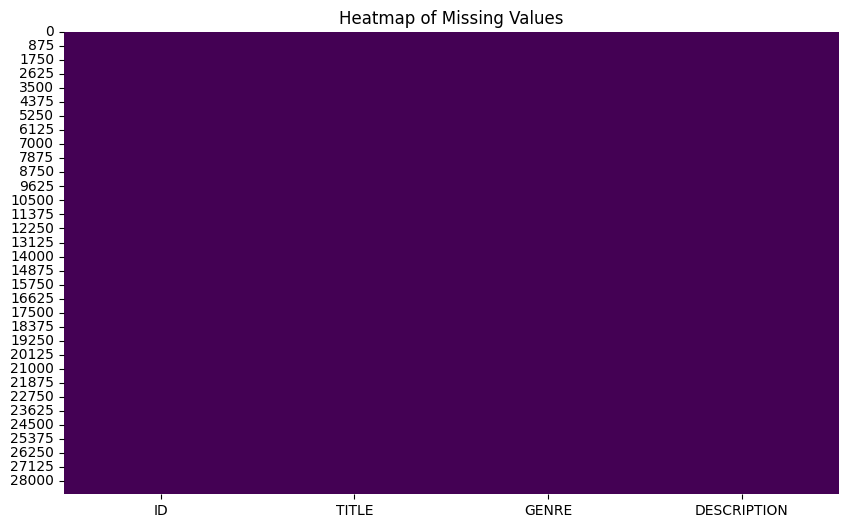

ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64


In [ ]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Drop rows with missing values in DESCRIPTION or GENRE
train_data = train_data.dropna(subset=['DESCRIPTION', 'GENRE'])

# Verify that there are no missing values left
print(train_data.isnull().sum())

In [ ]:
# Descriptive statistics for categorical columns
print(train_data.describe(include=['object']))

                                 TITLE    GENRE  \
count                            28844    28844   
unique                           28844       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1     7204   

                                              DESCRIPTION  
count                                               28844  
unique                                              28796  
top      A retired professor has returned to his estat...  
freq                                                    7  


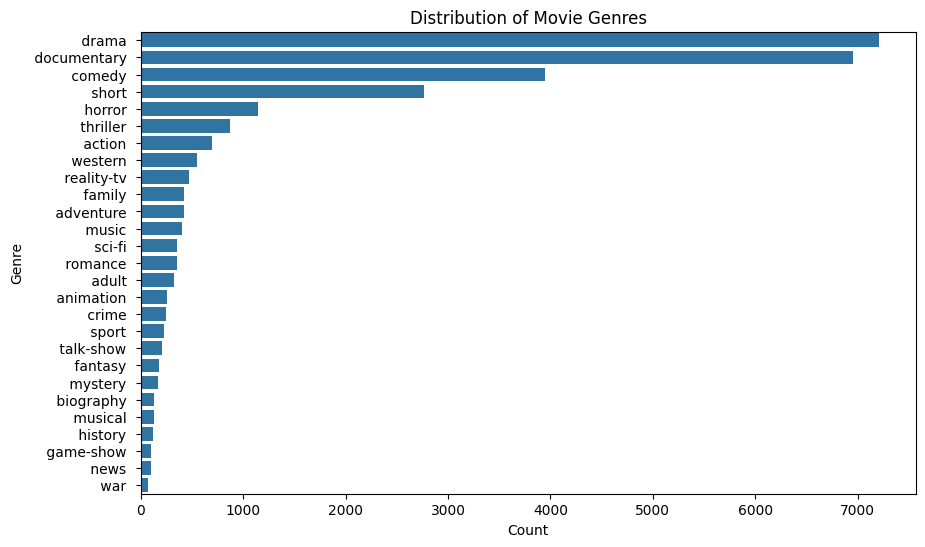

In [ ]:
# Genre distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=train_data['GENRE'], order=train_data['GENRE'].value_counts().index)
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

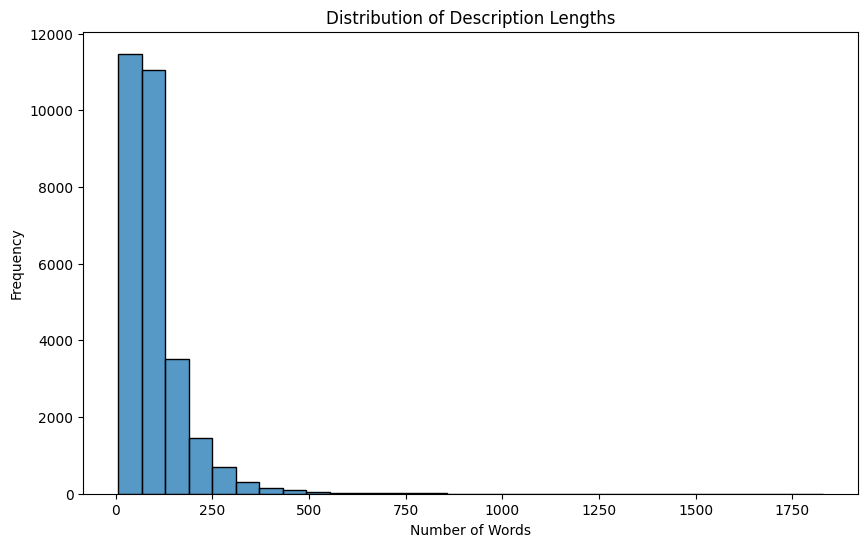

In [ ]:
# Length of descriptions
train_data['description_length'] = train_data['DESCRIPTION'].apply(lambda x: len(x.split()))

# Description length distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['description_length'], bins=30)
plt.title('Distribution of Description Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Text Cleaning Function

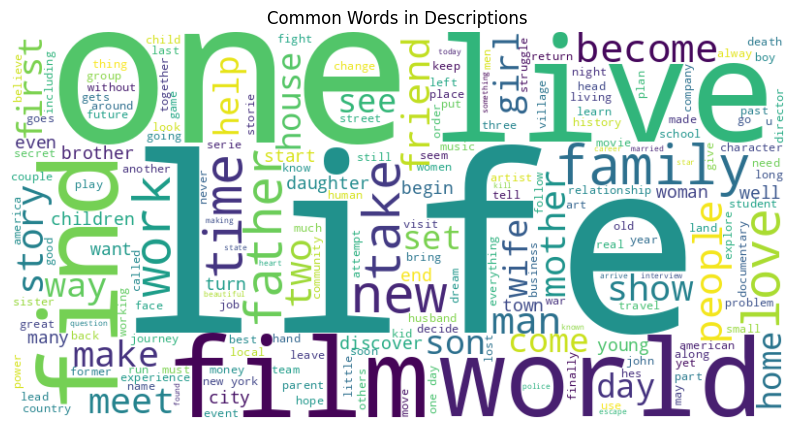

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply text cleaning
train_data['cleaned_description'] = train_data['DESCRIPTION'].apply(clean_text)
test_data['cleaned_description'] = test_data['DESCRIPTION'].apply(clean_text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data['cleaned_description']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Descriptions')
plt.show()

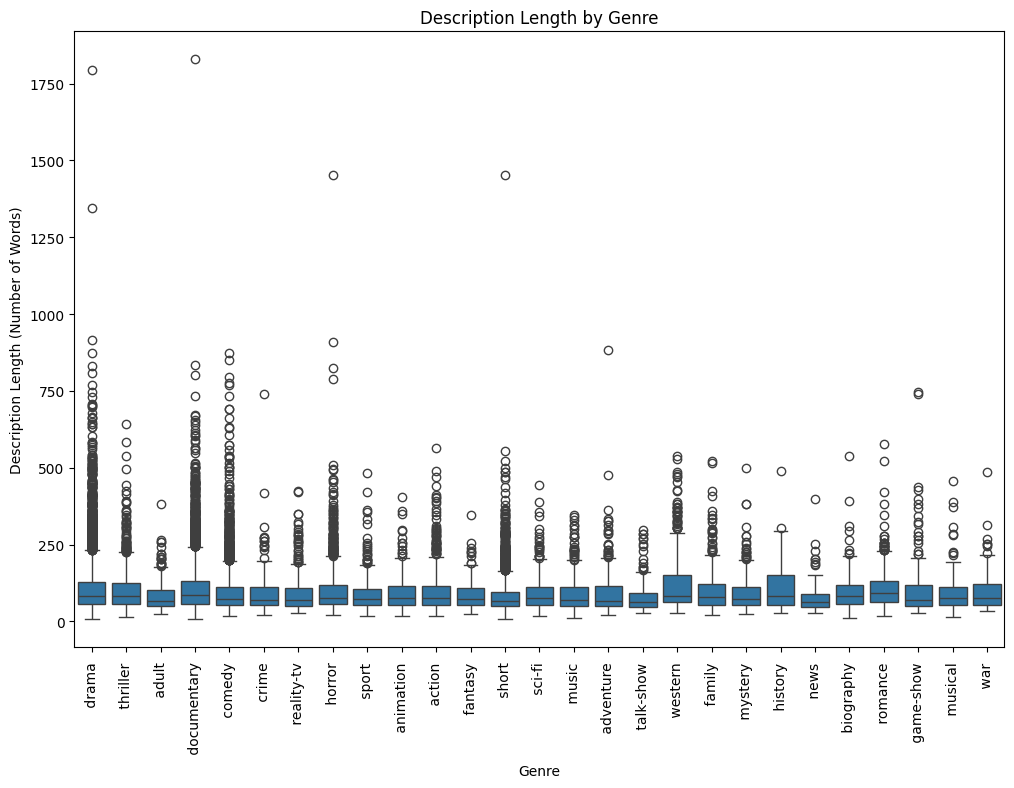

In [ ]:
# Boxplot of description length by genre
plt.figure(figsize=(12, 8))
sns.boxplot(x='GENRE', y='description_length', data=train_data)
plt.title('Description Length by Genre')
plt.xlabel('Genre')
plt.ylabel('Description Length (Number of Words)')
plt.xticks(rotation=90)
plt.show()


Feature Extraction using TF-IDF

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)

# Transform the training and test data
X_train = tfidf.fit_transform(train_data['cleaned_description']).toarray()
y_train = train_data['GENRE']
X_test = tfidf.transform(test_data['cleaned_description']).toarray()

Top Words per Genre

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top words per genre
genres = train_data['GENRE'].unique()
top_n = 10
for genre in genres:
    print(f"Top {top_n} words for genre: {genre}")
    genre_descriptions = train_data[train_data['GENRE'] == genre]['cleaned_description']
    common_words = get_top_n_words(genre_descriptions, top_n)
    print(common_words)


Top 10 words for genre:  drama 
[('life', 3455), ('young', 2262), ('love', 2182), ('family', 2011), ('story', 1667), ('man', 1597), ('father', 1547), ('new', 1472), ('mother', 1371), ('lives', 1298)]
Top 10 words for genre:  thriller 
[('life', 256), ('man', 198), ('young', 183), ('new', 183), ('murder', 146), ('finds', 138), ('wife', 133), ('world', 133), ('family', 131), ('police', 130)]
Top 10 words for genre:  adult 
[('sex', 137), ('young', 67), ('sexual', 59), ('woman', 56), ('girls', 55), ('gets', 52), ('women', 52), ('new', 50), ('scene', 45), ('girl', 44)]
Top 10 words for genre:  documentary 
[('film', 3468), ('documentary', 2535), ('life', 2253), ('world', 2213), ('people', 1867), ('story', 1757), ('new', 1680), ('years', 1641), ('time', 1186), ('history', 1030)]
Top 10 words for genre:  comedy 
[('life', 1052), ('new', 917), ('love', 840), ('comedy', 648), ('man', 639), ('friends', 611), ('time', 605), ('family', 595), ('young', 528), ('make', 528)]
Top 10 words for genre: 

Genre Correlation Matrix

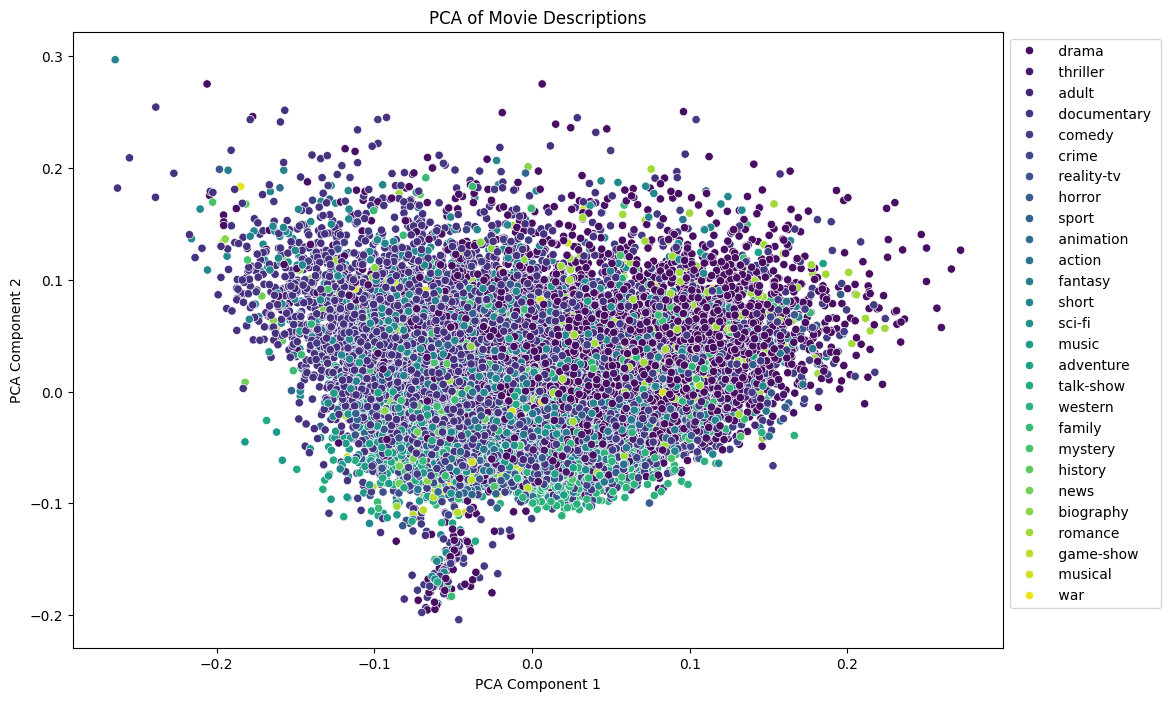

In [ ]:
# Convert descriptions to TF-IDF matrix
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_data['cleaned_description'])

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Add PCA components to the dataframe
train_data['pca1'] = X_pca[:, 0]
train_data['pca2'] = X_pca[:, 1]

# Plot PCA components colored by genre
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='GENRE', data=train_data, palette='viridis')
plt.title('PCA of Movie Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


##Model Training and model Evaluation

Data Processing

In [26]:
# Text preprocessing
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(train_data['DESCRIPTION'])

# Transform test data
X_test_tfidf = tfidf.transform(test_data['DESCRIPTION'])

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

Train-Validation Split

In [16]:
# Splitting the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, train_data['GENRE'], test_size=0.2, random_state=42)

Logistic regression

In [17]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val_lr = lr_model.predict(X_val)

# Evaluate the Logistic Regression model on the validation set
print("Logistic Regression Performance on Validation Set")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_lr)}")
print(classification_report(y_val, y_pred_val_lr))


Logistic Regression Performance on Validation Set
Accuracy: 0.46379853095487933
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        26
       adult        0.00      0.00      0.00        12
   adventure        0.00      0.00      0.00         8
   animation        0.00      0.00      0.00         5
   biography        0.00      0.00      0.00         7
      comedy        0.60      0.25      0.36       139
       crime        0.00      0.00      0.00         4
 documentary        0.49      0.90      0.63       233
       drama        0.42      0.85      0.56       229
      family        0.00      0.00      0.00        14
     fantasy        0.00      0.00      0.00         4
   game-show        0.00      0.00      0.00         7
     history        0.00      0.00      0.00         3
      horror        1.00      0.03      0.05        40
       music        0.00      0.00      0.00         7
     musical        0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Native Bayes

In [18]:
# Initialize and train the Naive Bayes (Multinomial) model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val_nb = nb_model.predict(X_val)

# Evaluate the Naive Bayes (Multinomial) model on the validation set
print("Naive Bayes (Multinomial) Performance on Validation Set")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_nb)}")
print(classification_report(y_val, y_pred_val_nb))


Naive Bayes (Multinomial) Performance on Validation Set
Accuracy: 0.4323189926547744
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        26
       adult        0.00      0.00      0.00        12
   adventure        0.00      0.00      0.00         8
   animation        0.00      0.00      0.00         5
   biography        0.00      0.00      0.00         7
      comedy        0.00      0.00      0.00       139
       crime        0.00      0.00      0.00         4
 documentary        0.52      0.88      0.66       233
       drama        0.37      0.90      0.52       229
      family        0.00      0.00      0.00        14
     fantasy        0.00      0.00      0.00         4
   game-show        0.00      0.00      0.00         7
     history        0.00      0.00      0.00         3
      horror        0.00      0.00      0.00        40
       music        0.00      0.00      0.00         7
     musical        0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [19]:
# Initialize and train the Support Vector Machine (SVM) model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val_svm = svm_model.predict(X_val)

# Evaluate the SVM model on the validation set
print("Support Vector Machine (SVM) Performance on Validation Set")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_svm)}")
print(classification_report(y_val, y_pred_val_svm))


Support Vector Machine (SVM) Performance on Validation Set
Accuracy: 0.4459601259181532
               precision    recall  f1-score   support

      action        0.00      0.00      0.00        26
       adult        0.00      0.00      0.00        12
   adventure        0.00      0.00      0.00         8
   animation        0.00      0.00      0.00         5
   biography        0.00      0.00      0.00         7
      comedy        0.75      0.11      0.19       139
       crime        0.00      0.00      0.00         4
 documentary        0.50      0.89      0.64       233
       drama        0.39      0.88      0.54       229
      family        0.00      0.00      0.00        14
     fantasy        0.00      0.00      0.00         4
   game-show        0.00      0.00      0.00         7
     history        0.00      0.00      0.00         3
      horror        0.00      0.00      0.00        40
       music        0.00      0.00      0.00         7
     musical        0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Hypertunning

In [29]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Initialize Grid Search
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=5, verbose=1, n_jobs=-1)

# Perform Grid Search
grid_search_lr.fit(X_train, y_train)

# Best parameters and model
best_lr_model = grid_search_lr.best_estimator_
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Logistic Regression: {'C': 100, 'solver': 'liblinear'}


##Saving the Model

In [30]:
joblib.dump(best_lr_model, 'genre_classification_model.pkl')

['genre_classification_model.pkl']